In [1]:
%matplotlib inline
import h5pyd
import os
import requests
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.interpolate import interp1d

## NSRBD Data for Site+Year

In [2]:
SITE_IDX = 131123 # closest NSRDB site to Fort Ross (used KD tree from demo)
SITE_TIMEZONE = 'America/Los_Angeles'
DATA_YEAR = '2016'

# pull the full year of ghi data for this site from NSRDB
# time_series will be a pandas DateTimeIndex localized to the site timezone.
def get_nsrdb_data():
    nsrdb_year = h5pyd.File(f'/nrel/nsrdb/v3/nsrdb_{DATA_YEAR}.h5', 'r')
    site_ghi_series = nsrdb_year['ghi'][:, SITE_IDX]

    # also pull the timestamps for the ghi data series, then localize them from UTC
    time_series_naive = pd.to_datetime(nsrdb_year['time_index'][...].astype(str))
    time_series = time_series_naive.tz_localize('UTC').tz_convert(SITE_TIMEZONE)
    return site_ghi_series, time_series


In [3]:
cached_data_path = f'cached/site-{SITE_IDX}-data-{DATA_YEAR}.pkl'
if os.path.exists(cached_data_path):
    print(f'Found {cached_data_path}, loading...')
    with open(cached_data_path, 'rb') as file:
        site_ghi_series, time_series = pickle.load(file)
else:
    print('No cached data found, querying NSRDB...')
    site_ghi_series, time_series = get_nsrdb_data()
    with open(cached_data_path, 'wb') as file:
        pickle.dump((site_ghi_series, time_series), file)

Found cached/site-131123-data-2016.pkl, loading...


### Narrow Data to Month

In [4]:
DATA_MONTH = '06'
# get start and end of selected month
start_of_month = pd.to_datetime(f'{DATA_YEAR}-{DATA_MONTH}-01').tz_localize(SITE_TIMEZONE)
end_of_month = start_of_month + pd.offsets.MonthEnd(1)
end_of_month = end_of_month.replace(hour=23, minute=59, second=59)
print(f'Start: {start_of_month}, end: {end_of_month}')

# Use a boolean mask to crop to that month in the timestamps and ghi data
month_mask = (time_series >= start_of_month) & (time_series <= end_of_month)
time_series_for_month = time_series[month_mask]
ghi_values_for_month = site_ghi_series[month_mask]

Start: 2016-06-01 00:00:00-07:00, end: 2016-06-30 23:59:59-07:00


### Chart GHI for Month

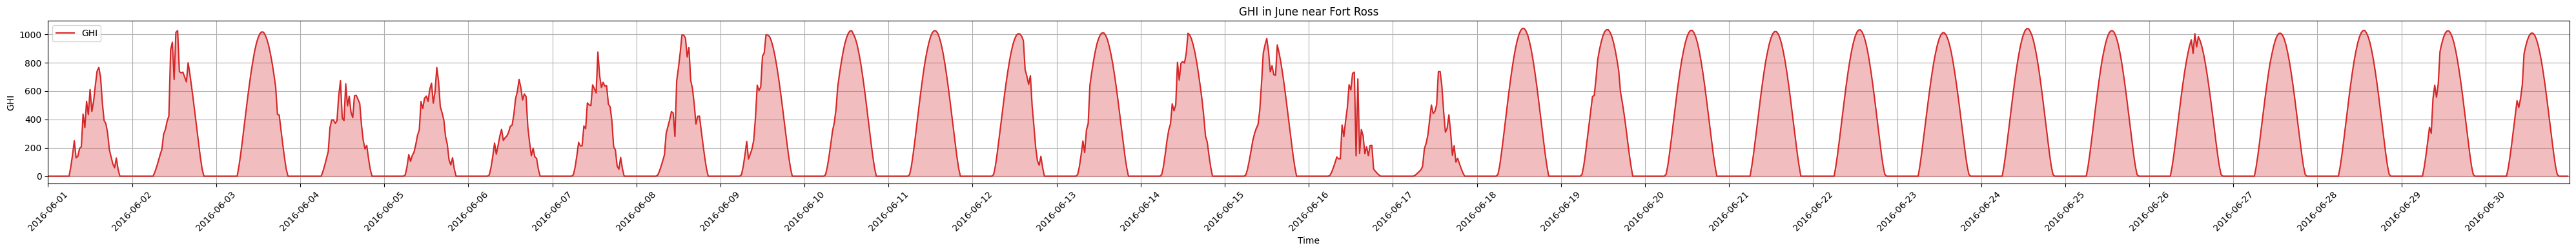

In [5]:
plt.figure(figsize=(40, 4))

# day_time_index_utc = day_time_index.tz_convert('UTC')
# plt.plot(day_time_index_utc, day_tseries, label='GHI')
plt.plot(time_series_for_month, ghi_values_for_month, label='GHI', color='tab:red')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))
plt.xlim(start_of_month, end_of_month)

plt.fill_between(time_series_for_month, ghi_values_for_month.min(), ghi_values_for_month, color='tab:red', alpha=0.3, zorder=2)

plt.title(f'GHI in {start_of_month.month_name()} near Fort Ross')
plt.xlabel('Time')
plt.ylabel('GHI')

plt.xticks(rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Get Tide Predictions

In [6]:
# Define the API parameters
params = {
    'product': 'predictions',
    'application': 'NOS.COOPS.TAC.WL',
    'begin_date': '20160531',
    'end_date': '20160701',
    'datum': 'MLLW', # is this reasonable? https://tidesandcurrents.noaa.gov/datum_options.html
    'station': '9416024',  # Fort Ross station ID
    'time_zone': 'lst_ldt',
    'units': 'english',
    'interval': 'hilo',
    'format': 'json'
}

url = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter'
tide_api_response = requests.get(url, params=params)

if tide_api_response.status_code == 200:
    tide_df = pd.DataFrame(tide_api_response.json()['predictions'])
    tide_df['t'] = pd.to_datetime(tide_df['t']).dt.tz_localize(SITE_TIMEZONE)
    tide_df['v'] = pd.to_numeric(tide_df['v'])
else:
    print('Failed to retrieve data:', tide_api_response.status_code)


### Reconstruct High-Res Tide with Interpolation

In [7]:
# Convert timestamps to a numeric format for interpolation
timestamps_numeric = mdates.date2num(tide_df['t'])
interpolator = interp1d(timestamps_numeric, tide_df['v'], kind='cubic', fill_value='extrapolate')

tide_high_res = interpolator(mdates.date2num(time_series_for_month))

## Chart Tide and Sun Overlaid

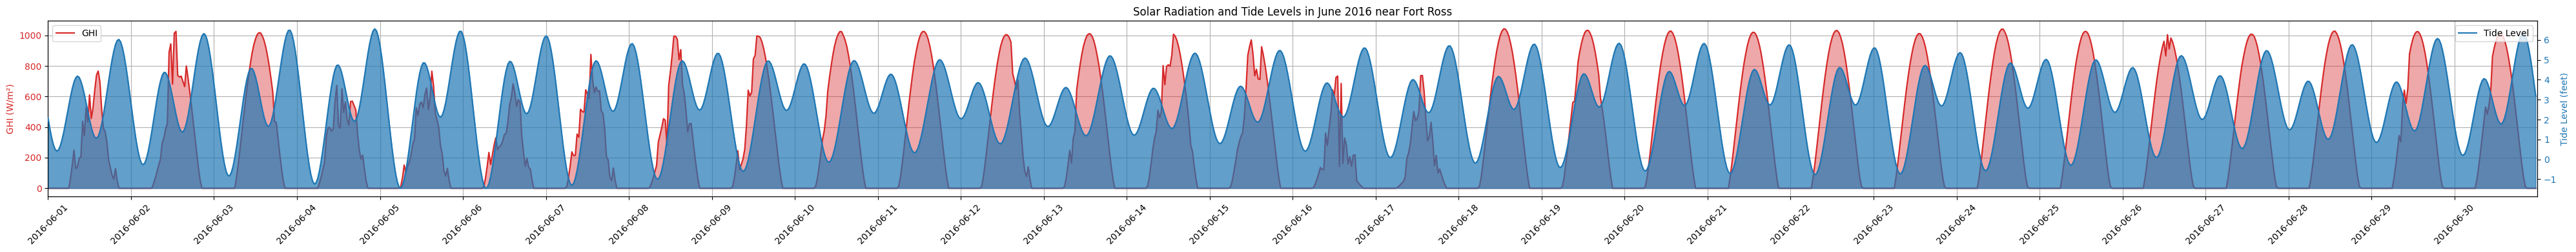

In [8]:
fig, ax1 = plt.subplots(figsize=(40, 4))

# Plot GHI data
ax1.plot(time_series_for_month, ghi_values_for_month, label='GHI', color='tab:red', zorder=3)
ax1.xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))
ax1.set_xlim(start_of_month, end_of_month)
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('GHI (W/m²)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Shade the area below the GHI line
ax1.fill_between(time_series_for_month, ghi_values_for_month.min(), ghi_values_for_month, color='tab:red', alpha=0.4, zorder=2)

# Create a secondary y-axis for tide data
ax2 = ax1.twinx()
ax2.plot(time_series_for_month, tide_high_res, label='Tide Level', color='tab:blue', linestyle='-', zorder=4)
ax2.set_ylabel('Tide Level (feet)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Shade the area above the tide line
ax2.fill_between(time_series_for_month, tide_high_res.min(), tide_high_res, color='tab:blue', alpha=0.7, zorder=1)

# Title, grid, and legend
ax1.set_title(f"Solar Radiation and Tide Levels in {start_of_month.strftime('%B %Y')} near Fort Ross")
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()


### Normalize Tide Data
We want to scale the solar radiation according to how low the tide was, so with our tide data currently in the range 0-1 where 0 is the lowest tide, we need to invert that so 0 is the highest tide, meaning the least solar radiation is getting absorbed.

In [9]:
min_val, max_val = tide_high_res.min(), tide_high_res.max()
tide_values_normalized = (tide_high_res - min_val) / (max_val - min_val)

## Graph Tide-Scaled Radiation
Note that the y-axis of the resulting chart is also scaled to a smaller GHI value.

In [10]:
tide_values_inverted = 1 - tide_values_normalized

assert tide_values_inverted.shape == ghi_values_for_month.shape
tide_scaled_ghi = tide_values_inverted * ghi_values_for_month

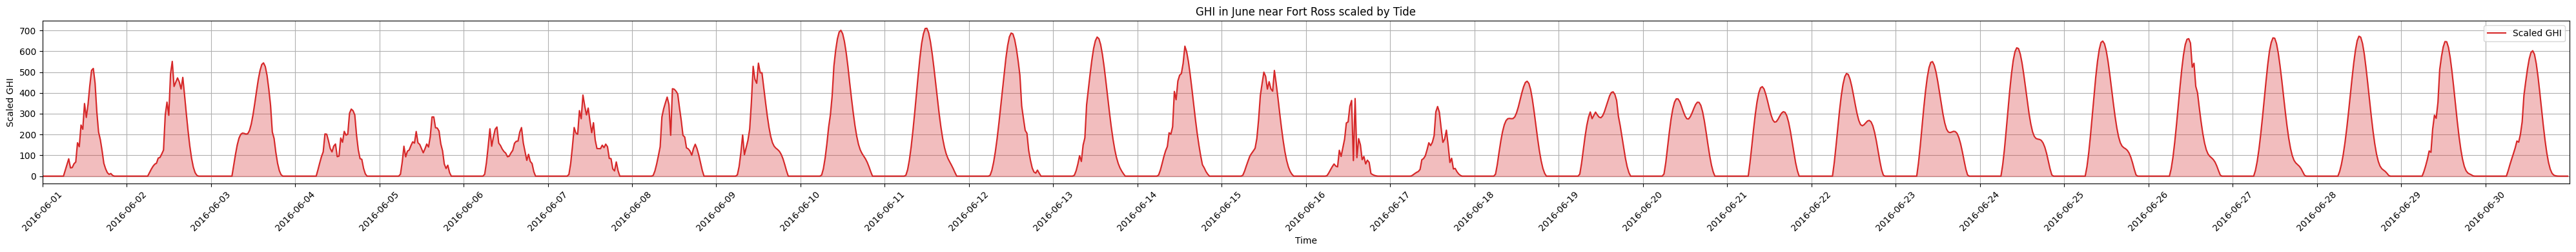

In [11]:
plt.figure(figsize=(40, 4))

# day_time_index_utc = day_time_index.tz_convert('UTC')
# plt.plot(day_time_index_utc, day_tseries, label='GHI')
plt.plot(time_series_for_month, tide_scaled_ghi, label='Scaled GHI', color='tab:red')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))
plt.xlim(start_of_month, end_of_month)

plt.fill_between(time_series_for_month, tide_scaled_ghi.min(), tide_scaled_ghi, color='tab:red', alpha=0.3, zorder=2)

plt.title(f'GHI in {start_of_month.month_name()} near Fort Ross scaled by Tide')
plt.xlabel('Time')
plt.ylabel('Scaled GHI')

plt.xticks(rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Graph Tide-Thresholded Radiation

In [12]:
TIDE_THRESHOLD = 0.50 # TODO where should this be from??
tide_thresholded_ghi = ghi_values_for_month * (tide_values_normalized < TIDE_THRESHOLD)

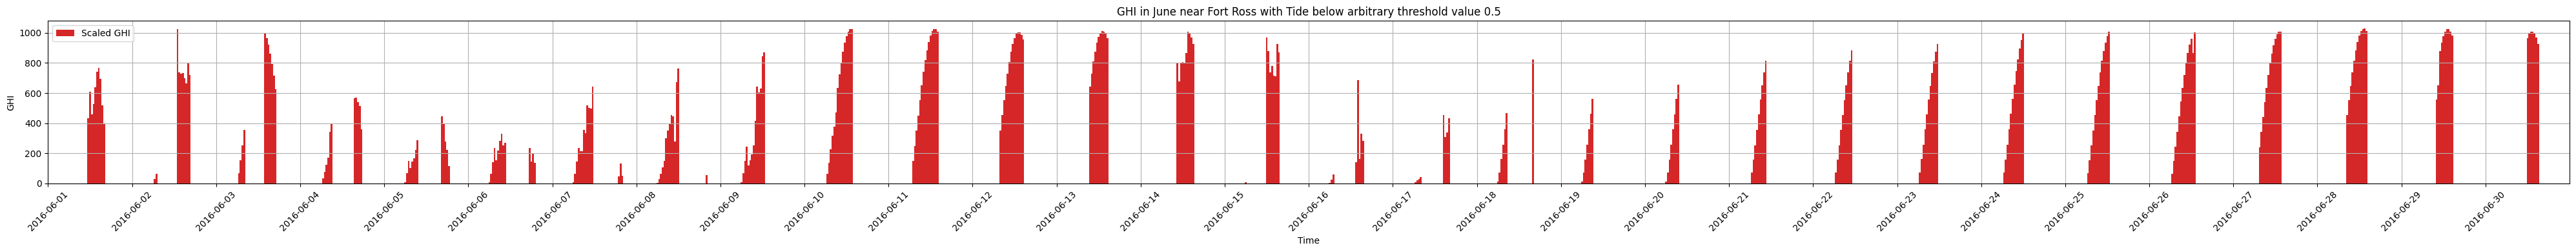

In [13]:
plt.figure(figsize=(40, 4))

# Calculating the width of each bar in days (assuming regular intervals)
if len(time_series_for_month) > 1:
    bar_width = (time_series_for_month[1] - time_series_for_month[0]).total_seconds() / (24 * 3600)
else:
    bar_width = 0.01  # default to a very small width if unable to calculate

plt.bar(time_series_for_month, tide_thresholded_ghi, width=bar_width, color='tab:red', label='Scaled GHI', align='center')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))
plt.xlim([start_of_month, end_of_month])

plt.title(f'GHI in {start_of_month.month_name()} near Fort Ross with Tide below arbitrary threshold value {TIDE_THRESHOLD}')
plt.xlabel('Time')
plt.ylabel('GHI')
plt.xticks(rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Graph Both Overlaid

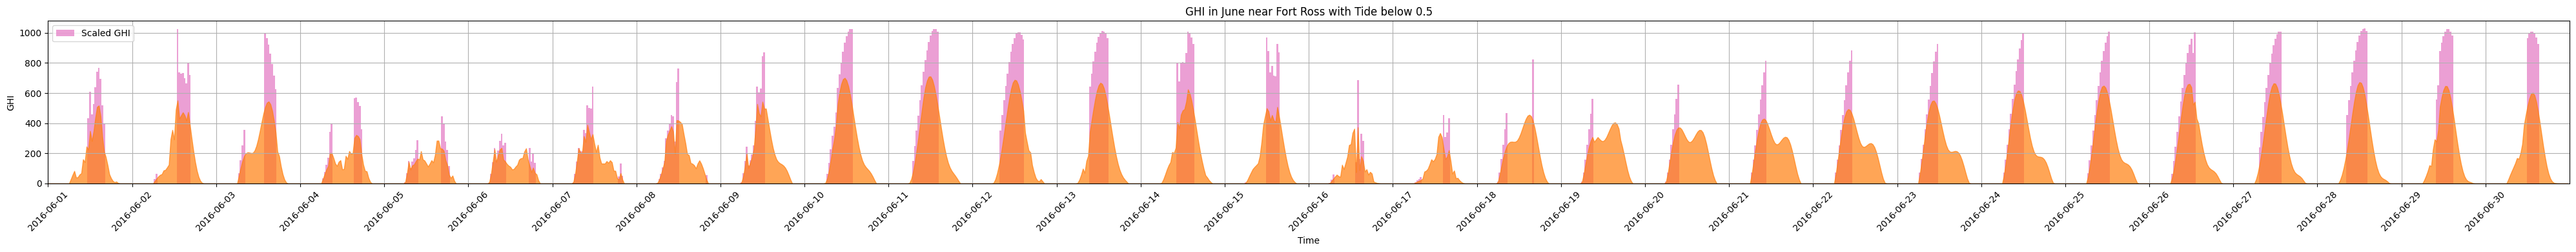

In [14]:
plt.figure(figsize=(40, 4))

# Calculating the width of each bar in days (assuming regular intervals)
if len(time_series_for_month) > 1:
    bar_width = (time_series_for_month[1] - time_series_for_month[0]).total_seconds() / (24 * 3600)
else:
    bar_width = 0.01  # default to a very small width if unable to calculate

plt.bar(time_series_for_month, tide_thresholded_ghi, width=bar_width, color='tab:pink', label='Scaled GHI', align='center', alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))
plt.xlim([start_of_month, end_of_month])

plt.fill_between(time_series_for_month, tide_scaled_ghi.min(), tide_scaled_ghi, color='tab:orange', alpha=0.7)

plt.title(f'GHI in {start_of_month.month_name()} near Fort Ross with Tide below {TIDE_THRESHOLD}')
plt.xlabel('Time')
plt.ylabel('GHI')
plt.xticks(rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Aggregate by Days
TODO: Dates are off in the labels for some reason

In [15]:
DATA_GRANULARITY = 48 # 48 measurements per day; twice hourly

def aggregate_data(data_series):
    total_measurements = data_series.size
    if total_measurements % DATA_GRANULARITY != 0:
        raise ValueError("The number of measurements is not consistent with whole days")
    num_days = total_measurements // DATA_GRANULARITY

    reshaped_data = data_series.reshape((num_days, DATA_GRANULARITY))
    return np.sum(reshaped_data, axis=1)

daily_tide_thresholded_ghi = aggregate_data(tide_thresholded_ghi)
daily_tide_scaled_ghi = aggregate_data(tide_scaled_ghi)

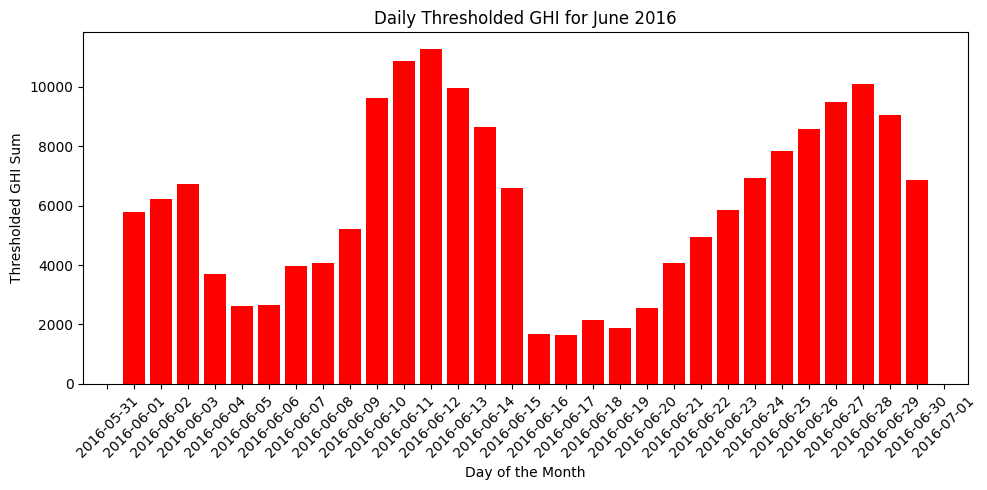

In [17]:
# Generate a date range for the month
plot_date_range = pd.date_range(start=f"{DATA_YEAR}-{DATA_MONTH}-01", periods=len(daily_tide_thresholded_ghi), freq='D', tz=SITE_TIMEZONE)

# Create the plot
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.bar(plot_date_range, daily_tide_thresholded_ghi, color='red')
plt.title(f'Daily Thresholded GHI for {plot_date_range[0].strftime("%B %Y")}')
plt.xlabel('Day of the Month')
plt.ylabel('Thresholded GHI Sum')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Improve the x-axis ticks to show each day
plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

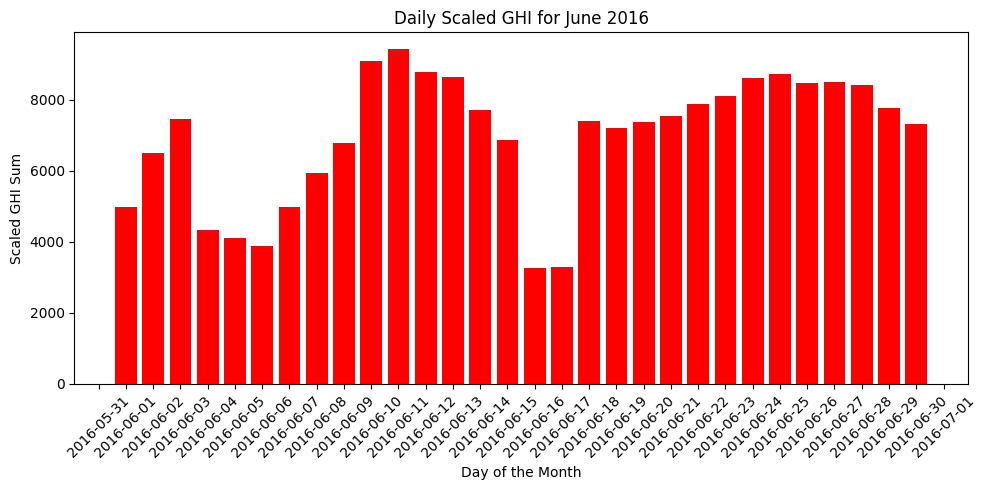

In [18]:
# Generate a date range for the month
plot_date_range = pd.date_range(start=f"{DATA_YEAR}-{DATA_MONTH}-01", periods=len(daily_tide_scaled_ghi), freq='D', tz=SITE_TIMEZONE)

# Create the plot
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.bar(plot_date_range, daily_tide_scaled_ghi, color='red')
plt.title(f'Daily Scaled GHI for {plot_date_range[0].strftime("%B %Y")}')
plt.xlabel('Day of the Month')
plt.ylabel('Scaled GHI Sum')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Improve the x-axis ticks to show each day
plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

## Next Steps


What do we really care about?
I'd like to be able to compare two places. how do I do that?


Are we building a "model that identifies heat waves"?
- well, no, because a definition of heat wave has never included tide before.
- if we ignore tides for a sec can we do that?

do we care about radiation from times other than peak sun?
- right now thos
 - could use a touch of clarification about which factors are important.
 - sun exposure/absorption, air temp, water temp, how does it all come together to be bad for organisms?

how often do heat waves happen across our coast / frequency of heat waves that have occurred

expand to year

include site intertidal data

20 sites across california

we care more about the deep intertidal and the hottest hot days

it would help to have a 'yes this period was a heat wave'... but noone's ever included tide in the analysis


this area had 5 events defined this way
